Notebook with some demonstrations of how to use NaMaster.

In [1]:
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
plt.style.use('supermongo')

In [162]:
nside = 128 # resolution
aposcale = 25 # apodization scale in degrees
nmc  = 5 # number of realizations of cmb
lmax = 3 * nside - 1
true_cls = np.loadtxt('cosmo_cls.txt')[:, : lmax + 1] # read in precomputed cmb spectra
true_cls[2] *= 0 # make sure BB is set to zero
ells = np.linspace(0, lmax, lmax + 1)

In [163]:
# generate nmc (T, Q, U) realizations of the spectrum 
mc_cmb_reals = np.array([hp.synfast(true_cls, nside, new=True, verbose=False) for _ in range(nmc)])

Define a binary mask, and an apodized version. This would be the observed sky region, and could be combined with an inverse-variance weight map for non-homogenous noise. This would also contain any holes corresponding to contaminated parts of the data etc...

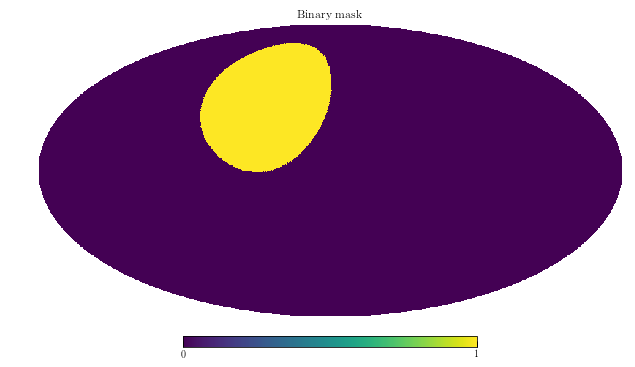

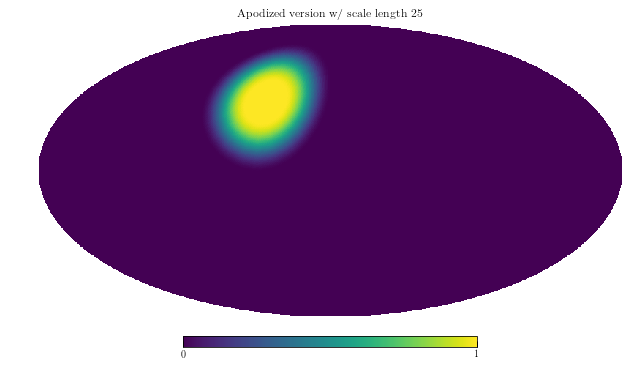

In [164]:
disc_ind = hp.query_disc(nside, (3., 3., 3.), 2. * np.pi / 10.)
mask = np.zeros(12 * nside ** 2)
mask[disc_ind] = 1
mask_apo = nmt.mask_apodization(mask, aposcale, 'C2')
hp.mollview(mask, title="Binary mask")
hp.mollview(mask_apo, title="Apodized version w/ scale length {:d}".format(int(aposcale)))

First let's demonstrate why we need 'purify' a pseudo-$C_\ell$ computation. The pseudo $a_{\ell m}$'s just correspond to a direct SHT of the maked data:

In [165]:
pseudo_alm_masked = hp.map2alm(mc_cmb_reals[0] * mask)
pseudo_alm_true = hp.map2alm(mc_cmb_reals[0])
pseudo_teb_map_masked = hp.alm2map(pseudo_alm_masked, nside, pol=False, verbose=False)
pseudo_teb_map_true = hp.alm2map(pseudo_alm_true, nside, pol=False, verbose=False)

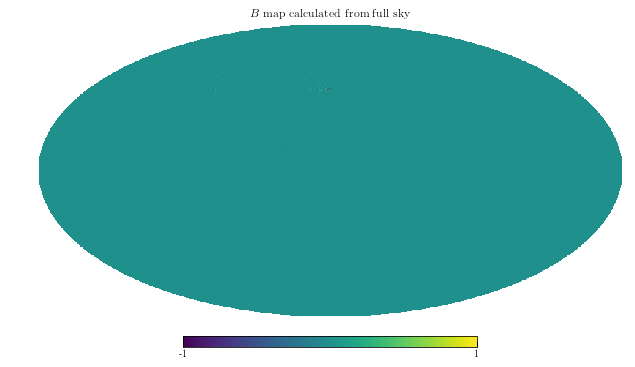

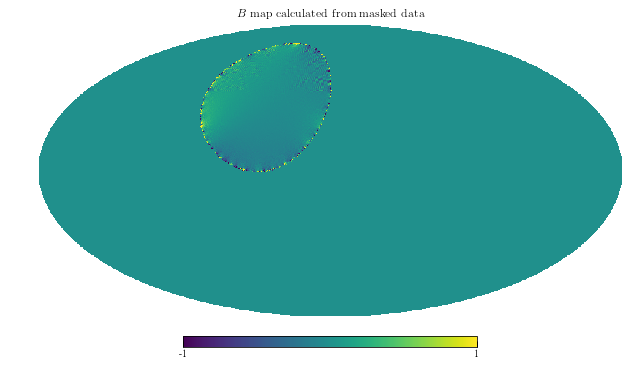

In [166]:
hp.mollview(pseudo_teb_map_true[2] * mask, title=r'$B$ map calculated from full sky', min=-1, max=1)
hp.mollview(pseudo_teb_map_masked[2] * mask, title=r'$B$ map calculated from masked data', min=-1, max=1)

We see some very small numerical artifacts in the true $B$ mode map. We see also the dominant leakage induced by the mask in the cut sky calculation. `NaMaster` will try to fix our estimate of the true $B$ mode at the map level by calculating the effects of the mask analytically and removing them. 

The `NaMaster` *pure estimator* has some boundary condition requirements on the mask:

- real
- apodized with Neuman and Dirichlet boundary conditions
- no sharp corners
- not too many holes

The last two conditions can not be avoided in practice, but do place limits on the efficacy of this method for extremely weird masks.

Using the apodized mask below, we can use `NaMaster` to calculate a purified map:

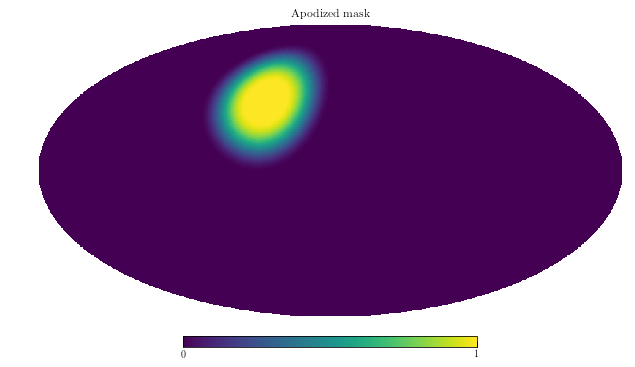

In [167]:
hp.mollview(mask_apo, title="Apodized mask")

In [187]:
def second_der(m):
    """ Function to calculate the second derivative of a spin-0 field.
    """
    # get the nside and construct array of multipoles from 0 to lmax.
    ns = hp.get_nside(m)
    lmax = 3 * ns
    ells = np.linspace(0, lmax, lmax + 1)
    # apply derivative in harmonic space (just a multiplication)
    wlm = hp.map2alm(m, lmax=lmax)
    fl = -1. / alpha_2(ells) * alpha_2(ells)
    # set monopole and dipole to zero, ill defined in derivative
    fl[[0, 1]] = 0
    w_e = hp.almxfl(wlm, fl)
    w_b = np.zeros_like(w_e)
    w_t = np.zeros_like(w_e)
    return hp.alm2map(w_e, ns, lmax=lmax, pol=False, fwhm=np.pi/180.*1)

def alpha_2(ell):
    """ Convenience function to calculate prefactors in derivative.
    """
    return np.sqrt(1. / ((ell - 1) * ell * (ell + 1) * (ell + 2)))

In [204]:
mask_apo = nmt.mask_apodization(mask, 20, 'C2')
mask_apo_der = second_der(mask_apo)

Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin


/home/ben/anaconda3/envs/pebbles/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/ben/anaconda3/envs/pebbles/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/ben/anaconda3/envs/pebbles/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


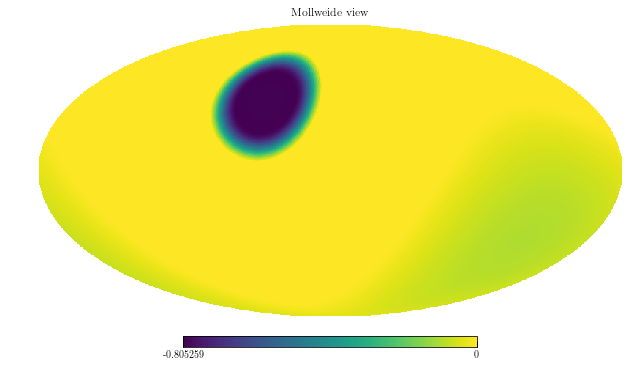

In [211]:
hp.mollview(mask_apo_der)

The `nmt.NmtField` object contains the data and the mask. Objects in `NaMaster` are separated depending on their spin. Therefore, we have to treat temperature and polarization separately. Below we are only using the $Q$ and $U$ maps from the CMB realizations.

In [168]:
field_binary = nmt.NmtField(mask, mc_cmb_reals[0, [1, 2]]) # version with binary mask
field_apo_pure = nmt.NmtField(mask_apo, mc_cmb_reals[0, [1, 2]], purify_b=True, purify_e=False) # apodized mask and purified estimator

We can retrieve purified $Q$ and $U$ maps using the `nmt.NmtField.get_map` method. Since these are yielded in real space we need to convert to $a_{\ell m}$'s to make a map of the $B$ modes.

In [173]:
nama_pseudo_qu = np.zeros((3, 12 * nside ** 2)) # map2alm requires three maps, so reinvent the temperature dimension
nama_pseudo_qu_pure = np.zeros((3, 12 * nside ** 2))
nama_pseudo_qu[[1, 2]] = field_binary.get_maps()
nama_pseudo_qu_pure[[1, 2]] = field_apo_pure.get_maps()

In [174]:
nama_pseudo_alm = hp.map2alm(nama_pseudo_qu)
nama_pseudo_pure_alm = hp.map2alm(nama_pseudo_qu_pure)

In [179]:
nama_pseudo_b = hp.alm2map(nama_pseudo_alm[2], nside, verbose=False)
nama_pseudo_b_pure = hp.alm2map(nama_pseudo_pure_alm[2], nside, verbose=False)

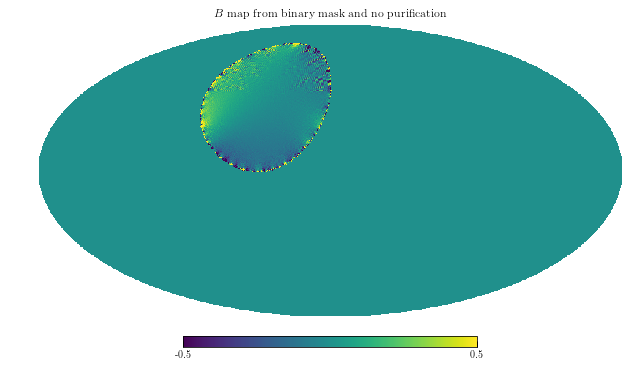

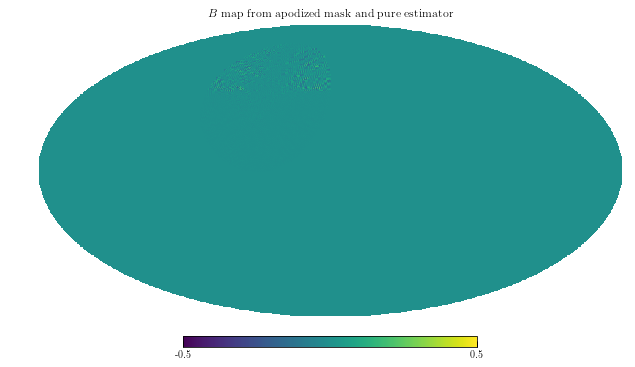

In [185]:
hp.mollview(nama_pseudo_b * mask, title='$B$ map from binary mask and no purification', min=-0.5, max=0.5)
hp.mollview(nama_pseudo_b_pure * mask, title='$B$ map from apodized mask and pure estimator', min=-0.5, max=0.5)

We now calculate these maps for a set of realizations of the CMB to see how they average down.

In [180]:
def calc_pseudo_eb(qu_maps, mask, pure_b=False):
    """ Function to take pair of Q and U maps, a mask, and compute their pseudo
    harmonic coefficients. This is done wither for the naive estimator (pure_b
    False) or for the pure estimator (pure_b True).
    
    Parameters
    ----------
    qu_maps: ndarray
        Array of shape (2, Npix) containing the input maps.
    mask: ndarray
        Array of shape (Npix) containing the mask to be applied to the maps.
    pure_b: bool (optional, default=False)
        If True (False) use the pure (impure) estimator.
        
    Returns
    -------
    ndarray
        Array of shape (3, Npix) containing the T, E, and B maps computed with 
        the requested estimator.
    """
    field = nmt.NmtField(mask_apo, qu_maps, purify_b=pure_b, purify_e=False)
    tqu = np.zeros((3, 12 * nside ** 2))
    tqu[[1, 2]] = field.get_maps()
    pseudo_alm = hp.map2alm(tqu)
    return np.array(hp.alm2map(pseudo_alm[[1, 2]], nside, pol=False, verbose=False))

In [181]:
pseudo_eb = np.array([calc_pseudo_eb(cmb[[1, 2]], mask) for cmb in mc_cmb_reals])
pseudo_mean = np.mean(pseudo_eb, axis=0)
pseudo_var = np.var(pseudo_eb, axis=0)

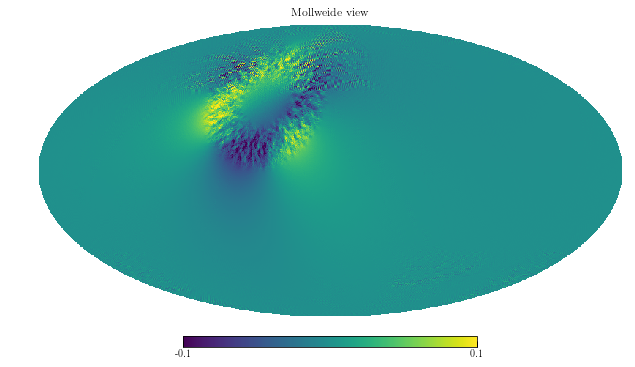

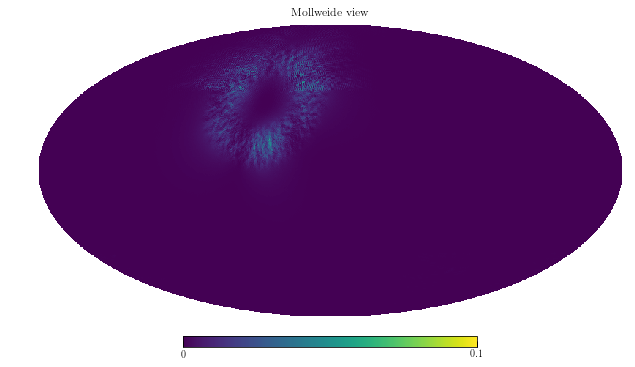

In [182]:
hp.mollview(pseudo_mean[1], min=-0.1, max=0.1)
hp.mollview(pseudo_var[1], min=0., max=0.1)

In [183]:
pseudo_pure_eb = np.array([calc_pseudo_eb(cmb[[1, 2]], mask_apo, pure_b=True) for cmb in mc_cmb_reals])
pseudo_pure_mean = np.mean(pseudo_pure_eb, axis=0)
pseudo_pure_var = np.var(pseudo_pure_eb, axis=0)

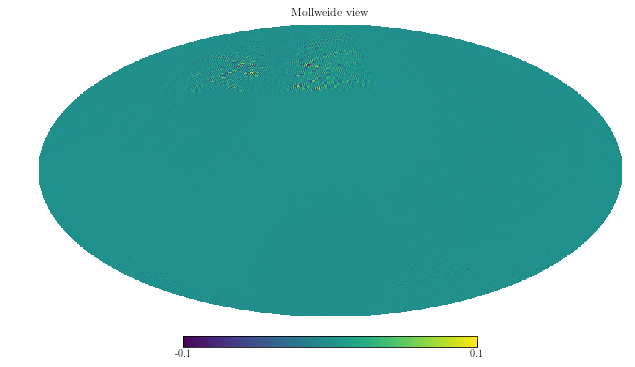

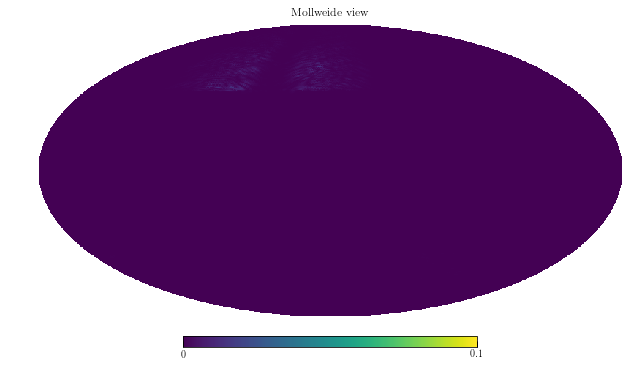

In [184]:
hp.mollview(pseudo_pure_mean[1], min=-0.1, max=0.1)
hp.mollview(pseudo_pure_var[1], min=0, max=0.1)

In [5]:
whole_sky = np.ones(12 * nside ** 2)

In [6]:
field1 = nmt.NmtField(whole_sky, mc_cmb_reals[0, [1, 2]], purify_b=False, purify_e=False)

In [8]:
nmtbin = nmt.NmtBin(nside, nlb=10)

In [9]:
cls = nmt.compute_full_master(field1, field1, nmtbin)

/home/ben/anaconda3/envs/perform/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


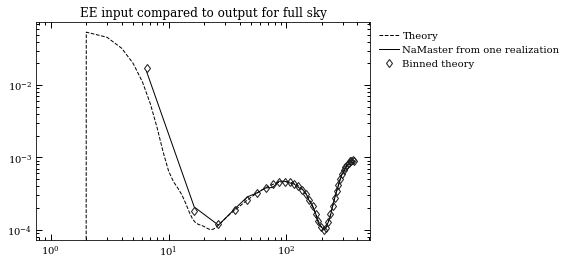

In [19]:
fig, ax = plt.subplots(1, 1)
ax.set_title('EE input compared to output for full sky')
ax.plot(ells, true_cls[1], linestyle='--', color='k', label='Theory')
ax.errorbar(nmtbin.get_effective_ells(), nmtbin.bin_cell(true_cls[1]), fmt='d', fillstyle='none', label='Binned theory')
ax.plot(nmtbin.get_effective_ells(), cls[0], color='k', label='NaMaster from one realization')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

Partial sky

In [137]:
disc_ind = hp.query_disc(nside, (3., 3., 3.), 2. * np.pi / 10.)
mask = np.zeros(12 * nside ** 2)
mask[disc_ind] = 1

0.09537251790364583


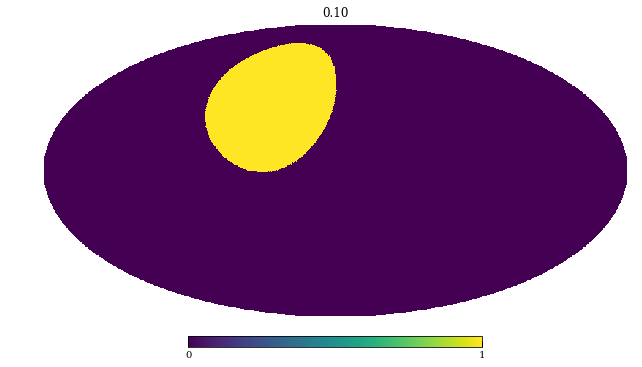

In [138]:
hp.mollview(mask, title='{:.02f}'.format(np.mean(mask ** 2) ** 2/ np.mean(mask ** 4)))
print(np.mean(mask))

In [140]:
field1 = nmt.NmtField(mask, mc_cmb_reals[0, [1, 2]], purify_b=False, purify_e=False)
cls = nmt.compute_full_master(field1, field1, nmtbin)

/home/ben/anaconda3/envs/perform/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


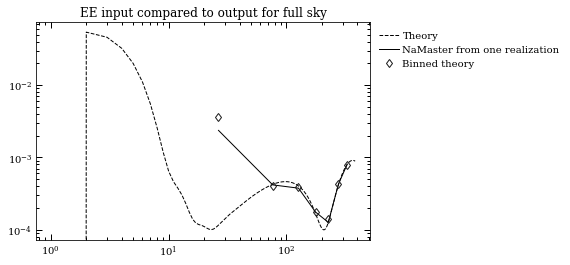

In [141]:
fig, ax = plt.subplots(1, 1)
ax.set_title('EE input compared to output for full sky')
ax.plot(ells, true_cls[1], linestyle='--', color='k', label='Theory')
ax.errorbar(nmtbin.get_effective_ells(), nmtbin.bin_cell(true_cls[1]), fmt='d', fillstyle='none', label='Binned theory')
ax.plot(nmtbin.get_effective_ells(), cls[0], color='k', label='NaMaster from one realization')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [142]:
mask = nmt.mask_apodization(mask, 10., apotype='C2')
nmtbin = nmt.NmtBin(nside, nlb=10)
field1 = nmt.NmtField(mask, mc_cmb_reals[0, [1, 2]], purify_b= True)
cls = nmt.compute_full_master(field1, field1, nmtbin)

/home/ben/anaconda3/envs/perform/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


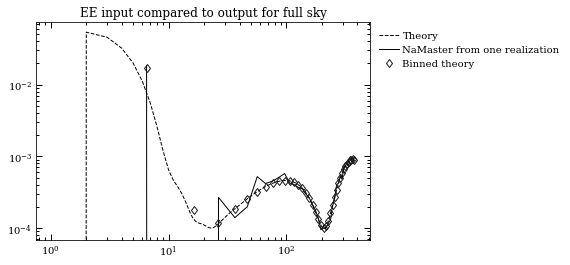

In [143]:
fig, ax = plt.subplots(1, 1)
ax.set_title('EE input compared to output for full sky')
ax.plot(ells, true_cls[1], linestyle='--', color='k', label='Theory')
ax.errorbar(nmtbin.get_effective_ells(), nmtbin.bin_cell(true_cls[1]), fmt='d', fillstyle='none', label='Binned theory')
ax.plot(nmtbin.get_effective_ells(), cls[0], color='k', label='NaMaster from one realization')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

/home/ben/anaconda3/envs/perform/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


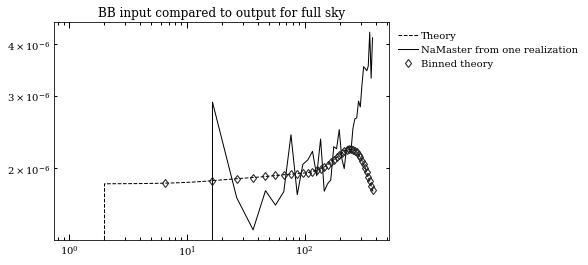

In [144]:
fig, ax = plt.subplots(1, 1)
ax.set_title('BB input compared to output for full sky')
ax.plot(ells, true_cls[2], linestyle='--', color='k', label='Theory')
ax.errorbar(nmtbin.get_effective_ells(), nmtbin.bin_cell(true_cls[2]), fmt='d', fillstyle='none', label='Binned theory')
ax.plot(nmtbin.get_effective_ells(), cls[3], color='k', label='NaMaster from one realization')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [145]:
decoupled_cls = np.zeros((nmc, 4, nmtbin.get_n_bands()))
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(field1, field1, nmtbin)
for i in range(nmc):
    field = nmt.NmtField(mask, mc_cmb_reals[i, [1, 2]], purify_b=True)
    coupled_cls = nmt.compute_coupled_cell(field, field)
    decoupled_cls[i] = wsp.decouple_cell(coupled_cls)

In [146]:
cls_mean = np.mean(decoupled_cls, axis=0)
cls_cov = np.cov(decoupled_cls[:, 3, :], rowvar=False)
cls_inv_cov = np.linalg.inv(cls_cov)
yerr = 1./np.sqrt(np.diag(cls_inv_cov))

/home/ben/anaconda3/envs/perform/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


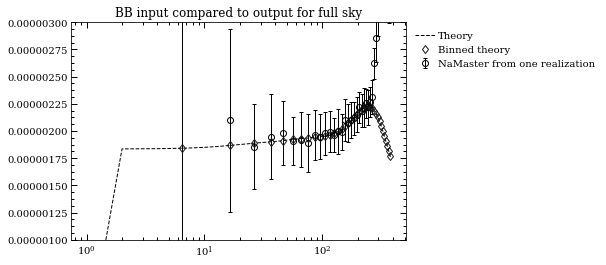

In [147]:
fig, ax = plt.subplots(1, 1)
ax.set_title('BB input compared to output for full sky')
ax.plot(ells, true_cls[2], linestyle='--', color='k', label='Theory')
ax.errorbar(nmtbin.get_effective_ells(), nmtbin.bin_cell(true_cls[2]), fmt='d', fillstyle='none', label='Binned theory')
ax.errorbar(nmtbin.get_effective_ells(), cls_mean[3], yerr=yerr, fmt='o', fillstyle='none', color='k', label='NaMaster from one realization')
ax.set_yscale('linear')
ax.set_xscale('log')
ax.set_ylim(1e-6, 3e-6)
ax.minorticks_on()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [148]:
theory_pol = np.zeros_like(true_cls)
theory_pol[[0, 3]] = true_cls[[1, 2]]
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(field1, field1, nmtbin)

In [149]:
true_cls_coupled = wsp.decouple_cell(wsp.couple_cell(theory_pol))

/home/ben/anaconda3/envs/pebbles/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


/home/ben/anaconda3/envs/perform/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


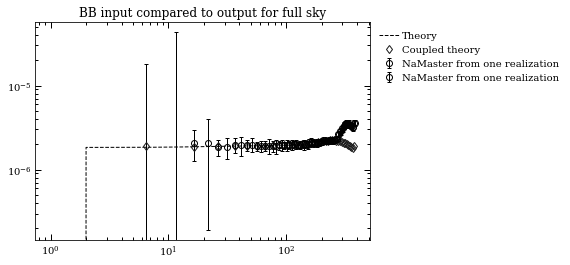

In [150]:
fig, ax = plt.subplots(1, 1)
ax.set_title('BB input compared to output for full sky')
ax.plot(ells, true_cls[2], linestyle='--', color='k', label='Theory')
ax.errorbar(nmtbin.get_effective_ells(), true_cls_coupled[3], fmt='d', fillstyle='none', label='Coupled theory')
ax.errorbar(nmtbin.get_effective_ells(), cls_mean[3], yerr=yerr, fmt='o', fillstyle='none', color='k', label='NaMaster from one realization')
ax.errorbar(nmtbin.get_effective_ells() + 5, cls_mean[3], yerr=np.diag(np.sqrt(cls_cov)), fmt='o', fillstyle='none', color='k', label='NaMaster from one realization')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')